In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
cd ..

C:\Users


In [3]:
cd ..

C:\


In [4]:
cd Penn State\Projects\Lane Detection\Dataset

C:\Penn State\Projects\Lane Detection\Dataset


In [5]:
import os
os.getcwd()

'C:\\Penn State\\Projects\\Lane Detection\\Dataset'

In [6]:
import pandas as pd
import numpy as np
import keras
import h5py
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from keras.preprocessing import image
from keras.layers.core import Dropout, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add, Flatten, UpSampling2D, BatchNormalization
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input
from keras.optimizers import Adam, Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Deconvolution2D

Using TensorFlow backend.


In [7]:
%%time

train = []

for file in os.listdir(os.path.join(os.getcwd(), 'RGB_data')):
    train.append([os.path.join(os.getcwd(), 'RGB_data', file),
                     os.path.join(os.getcwd(), 'Segmented_data', file)])
train = pd.DataFrame(train, columns=['Camera_Image', 'Segmented_Images'])

Augmented_data = []

for file in os.listdir(os.path.join(os.getcwd(), 'Augmented_RGB')):
    Augmented_data.append([os.path.join(os.getcwd(), 'Augmented_RGB', file),
                     os.path.join(os.getcwd(), 'Augmented_Seg', file)])
    
Augmented_data = pd.DataFrame(Augmented_data, columns=['Camera_Image', 'Segmented_Images'])

Train_data = [train, Augmented_data]
Train_data = pd.concat(Train_data)

RGB = []
Segmented= []

for i in range(len(Train_data)):
    img = cv2.imread(Train_data.iloc[i][0])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGB.append(img)
    img = cv2.imread(Train_data.iloc[i][1])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    Segmented.append(img)
    if i%999 == 0:
        print(i," images are done")
    if i==3000:
        break
RGB = np.array(RGB) #Camera RGB data
Segmented = np.array(Segmented) #Segmented data

0  images are done
999  images are done
1998  images are done
2997  images are done
Wall time: 46.9 s


In [8]:
del train
del Augmented_data
del Train_data

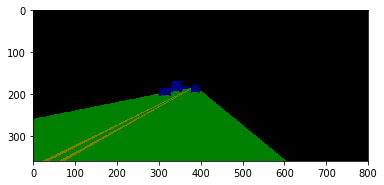

In [9]:
plt.imshow(Segmented[634])

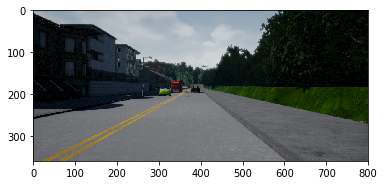

In [10]:
plt.imshow(RGB[634])

In [11]:
print('Shape of RGB: ', RGB.shape, '  Shape of Segmented: ', Segmented.shape)

Shape of RGB:  (3001, 360, 800, 3)   Shape of Segmented:  (3001, 360, 800, 3)


In [12]:
"""smooth = 1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)"""

In [13]:
%%time
#RGB, RGB_val, Segmented, Segmented_val = train_test_split(RGB, Segmented, test_size = 0.2, shuffle = True, random_state=125)

Wall time: 0 ns


In [14]:
#print("Training images:{}".format(RGB.shape[0]), "    Validation images:{}".format(RGB_val.shape[0]))

In [15]:
#from keras.applications.resnet50 import ResNet50

In [16]:
#res  = ResNet50(include_top=False, weights=None, input_shape=(360, 800, 3))

In [17]:
#res.summary()

In [18]:
image_input=Input(shape=(360, 800, 3))

In [19]:
from keras.layers import *

def GCN(c, k, ip):
    G_L1 = Conv2D(c, (k,1), padding='same')(ip)
    G_L2 = Conv2D(c, (1,k), padding='same')(G_L1)
    G_R1 = Conv2D(c, (1,k), padding='same')(ip)
    #print(G_R1.shape)
    G_R2 = Conv2D(c, (k,1), padding='same')(G_R1)
    #print(G_R1.shape)
    return Add()([G_L2, G_R2])


def BR(c, k, ip):
    B_L1 = Conv2D(c, (k,1), padding='same')(ip)
    B_L2 = BatchNormalization()(B_L1)
    B_L2 = LeakyReLU(alpha=0.15)(B_L2)
    B_L3 = Conv2D(c, (k,1), padding='same')(B_L2)
    return Add()([B_L3, ip])

def Conv_block(inp, f1, f2):
    x = Conv2D(f1, (3,3), padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(f2, (3,3), padding = 'same', activation= 'relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    return x



#Input
ip = Input(shape=(360, 800, 3))

#Conv Block1
x1 = Conv_block(ip, 4, 10)
#print(x1)

#Conv Layer2
x2 = Conv_block(x1, 8, 15)
#print(x2)

#Conv Layer3
x3 = Conv_block(x2, 16, 20)
#print(x3)


#Conv Layer4
x4 = Conv_block(x3, 32, 30)
#print(x4)

#Conv Layer5
x5 = Conv2D(40, (3,3), padding = 'same')(x4)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)
x5 = Conv2D(50, (3,3), padding = 'same', activation= 'relu')(x5)

#print(x5)
x5 = GCN(30, 3, x5)
x5 = BR(30, 3, x5)


#Deconv5
#x5 = Deconvolution2D(30, 3, 3, output_shape= (24, 50,30), activation='relu')(x5)
#x5 = Conv2DTranspose(30, 3, strides=(2, 2), padding='valid')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)
#print(x5)

#Add 4 and 5
x5 = Add()([x5, x4])
x5 = GCN(25, 3, x5)
x5 = BR(25, 3, x5)

#print(x5)
#Deconv4
x5 = Conv2DTranspose(20, (3,2), strides=(2, 2), padding='valid')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)
#print(x5)

#Add 3 and 4
x5 = Add()([x5, x3])
x5 = GCN(25, 3, x5)
x5 = BR(25, 3, x5)


#Deconv3
#x5 = Deconvolution2D(15, 3, 3, output_shape= x2.output_shape, activation='relu')(x5)
x5 = Conv2DTranspose(15, (2,2), strides=(2, 2), padding='valid')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)

#Add 3 and 4
x5 = Add()([x5, x2])
x5 = GCN(20, 3, x5)
x5 = BR(20, 3, x5)


#Deconv2
#x5 = Deconvolution2D(10, 3, 3, output_shape= x1.output_shape, activation='relu')(x5)
x5 = Conv2DTranspose(10, (2,2), strides=(2, 2), padding='valid')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)

#Add 3 and 4
x5 = Add()([x5, x1])
x5 = GCN(15, 3, x5)
x5 = BR(15, 3, x5)


#Deconv1
#x5 = Deconvolution2D(3, 3, 3, output_shape= (-1, 3, 360,800), activation='relu')(x5)
x5 = Conv2DTranspose(3, (2,2), strides=(2, 2), padding='valid')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)
x5 = GCN(3, 3, x5)
x5 = BR(3, 3, x5)


model_new = Model(ip, x5)
model_new.summary()
 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 360, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 360, 800, 4)  112         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 360, 800, 4)  16          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 360, 800, 4)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
from keras.metrics import categorical_accuracy
from keras import optimizers

In [21]:
Ndm = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

In [22]:
model_new.compile(optimizer='Adam', loss = 'mse', metrics = [categorical_accuracy])

In [25]:
history = model_new.fit(RGB, Segmented, epochs=40, batch_size=16, validation_split=0.2)

Train on 2400 samples, validate on 601 samples
Epoch 1/40
2400/2400 [==============================] - 113s 47ms/step - loss: 1466.9081 - categorical_accuracy: 0.3355 - val_loss: 1371.5031 - val_categorical_accuracy: 0.2635
Epoch 2/40
2400/2400 [==============================] - 110s 46ms/step - loss: 857.3163 - categorical_accuracy: 0.2763 - val_loss: 700.2026 - val_categorical_accuracy: 0.2761
Epoch 3/40
2400/2400 [==============================] - 111s 46ms/step - loss: 310.7305 - categorical_accuracy: 0.2778 - val_loss: 614.3638 - val_categorical_accuracy: 0.2738
Epoch 4/40
2400/2400 [==============================] - 111s 46ms/step - loss: 207.0330 - categorical_accuracy: 0.2776 - val_loss: 331.0899 - val_categorical_accuracy: 0.2737
Epoch 5/40
2400/2400 [==============================] - 111s 46ms/step - loss: 167.3755 - categorical_accuracy: 0.2783 - val_loss: 140.9769 - val_categorical_accuracy: 0.2799
Epoch 6/40
2400/2400 [==============================] - 111s 46ms/step - los

In [26]:
model_new.save('Lane_MOdel_U_GCN.h5')

In [28]:
model_yaml = model_new.to_yaml()
with open("Lane_MOdel_U_GCN_OnlyModel.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)


In [27]:
model_new.save_weights('Lane_MOdel_U_GCN_OnlyWeights.h5')

In [ ]:
y_5 = model_new.predict(RGB[2:5])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(y_5[2])

In [ ]:
cv2.imwrite('test.png',y_5[2])

In [ ]:
added_image = cv2.addWeighted(RGB[2],1,y_5[0],1,0)

In [ ]:
from keras.applications.resnet50 import preprocess_input
image2 = preprocess_input(image.astype(np.float32),mode='tf')


In [ ]:
height, width = image.shape[:2]


In [ ]:
pred = np.argmax(RGB[634])


In [ ]:
road = np.dstack((np.zeros_like(pred),pred==1,np.zeros_like(pred)))


In [ ]:
cars = np.dstack((np.zeros_like(pred),np.zeros_like(pred),pred==2))
    

In [ ]:
cars0 = np.zeros(shape=(height,width,3)).astype('uint8')
    

In [ ]:
cars0[208:-72,:,:] = np.round(cars)
    

In [ ]:
road0 = np.zeros(shape=(height,width,3)).astype('uint8')
    

In [ ]:
road0[208:-72,:,:] = np.round(road)
    

In [ ]:
image = image.astype('uint8')
    

In [ ]:
image = cv2.addWeighted(image, 1.0, np.round(road0).astype('uint8')*255, 0.5, 0)
    

In [ ]:
image = cv2.addWeighted(image, 1.0, np.round(cars0).astype('uint8')*255, 0.7, 0)

In [ ]:
plt.imshow(image)

In [ ]:
blanks = np.zeros_like(Segmented[0]).astype(np.uint8)
lane_drawn = np.dstack((blanks, RGB[0], blanks))

In [ ]:
lane_drawn.shape


In [ ]:
i = 3
image = RGB[i]
Simage =Segmented[i]
added_image = cv2.addWeighted(image,1,Simage,1,0)

In [ ]:
plt.imshow(added_image)

In [ ]:

ret, thresh = cv2.threshold(imgray.astype(np.uint8), 20, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

if len(contours) != 0:
    # draw in blue the contours that were founded
    cv2.drawContours(lane_drawn, contours, -1, 255, 3)

        # find the biggest area
    c = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(c)
        # draw the book contour (in green)
    cv2.rectangle(lane_drawn, (x, y), (x + w, y + h), (0, 255, 0), 2)
lane_image = imresize(lane_drawn, (360, 800, 3))
    #cv2.polylines(lane_image,average_position_left_lower,False,(255,0,0))

average_position_left_lower = (0, 0)
average_position_left_upper =(0, 0)
average_position_right_lower =(0, 0)
average_position_right_upper =(0, 0)
   #print("R", lane_image[:, :, 0])


           #cv2.imshow("laneImage",lane_image)
           #print("G",lane_image[x, y, 1])
           #print("B",lane_image[x, y, 2])

           #print(x,y)
           #cv2.waitKey(1)



    # Merge the lane drawing onto the original image
cv2.imshow("laneImage",lane_image)
result = cv2.addWeighted(image, 1, lane_image, 1, 0)
cv2.imshow("Live",result)

In [ ]:
from keras.layers import deconvolution2D